Importação das bibliotecas

In [1]:
import copy
from time import perf_counter, process_time

from matplotlib import pyplot as plt

import numpy as np

Configurações de colunas e linhas do mundo, ações que o agente pode executar, posições de início, vitória, objeto e locais impassáveis

In [2]:
BOARD_ROWS = 6
BOARD_COLS = 7
WIN_STATE = [(0, 2), (0, 3), (0, 4)]
UNWALKABLE = [(1, 3), (4, 0), (4, 1), (4, 3), (4, 4), (4, 5), (4, 6), (5, 6)]
OBJECT_POSITION = [(2, 3)]
START = (5, 0)

#Ações que podem ser executadas
#Cada index coresponde a uma ação: 0 = up, 1 = right, 2 = down, 3 = left, 4 = do nothing
ACTIONS = ["up", "right", "down", "left", "nothing"]

Classes para serem usadas na simulação:

In [3]:
class State:
    """
    Estado de um agente
    """
        
    def __init__(self, position=START):
        self.object_position = None
        self.position = position
        self.is_end = False
        
    def has_object(self):
        return self.object_position != None
        
    def __str__(self):
        return f'Posição: {self.position}\nObject Position(has object: {self.has_object()}): {self.object_position}\nIs end: {self.is_end}'
    
    def _repr_pretty_(self, p, cycle):
        p.text(str(self) if not cycle else '...')

In [4]:
class Environment:
    """
    Ambiente sobre o qual o agente irá interagir
    """
    def __init__(self, rows=BOARD_ROWS, columns=BOARD_COLS, win=WIN_STATE, unwalkable=UNWALKABLE, object_position=OBJECT_POSITION):
        self.board = np.zeros([rows, columns])
        self.win = win
        self.unwalkable = unwalkable
        self.object_position = object_position
        
    def give_reward(self, new_state, old_state):
        """ Recompensa que o agente recebe pelo novo estado estado
        """
        if not old_state.has_object() and new_state.has_object():
            return 1 # recompensa por achar o objeto
        elif new_state.object_position in self.win:
            return 1 # recompensa por chegar com o objeto na base
        else:
            return -1

    def is_end_state(self, state):
        """ Verifica se o estado é um estado terminal
        """
        if state.object_position in self.win:
            state.is_end = True

    def next_state(self, state, action):
        """ Retorna o próximo estado
        
        Retorna o próximo estado com base na ação praticada sobre o estado atual.
        Pode retonar uma cópia do estado atual caso o agente não se mova ou não possa se mover.
        """
        # ação de nada já retorna direto o próprio estado
        if (action == "nothing"):
            return copy.deepcopy(state)
        
        nxtAgentPosition = self._give_position_by_action(state.position, action)
        if state.has_object():
            nxtObjectPosition = self._give_position_by_action(state.object_position, action)
        
        # a posição legal do agente não deve invadir paredes, nem bater no objeto se o agente não tiver o objeto
        is_legal_agent_position = self._is_legal_position(nxtAgentPosition) \
                                    and (state.has_object() or (not state.has_object() and nxtAgentPosition not in self.object_position))
        
        # se não tiver o objeto ele não deve influenciar na legalidade do movimento
        is_legal_object_position = self._is_legal_position(nxtObjectPosition) if state.has_object() else True

        if is_legal_agent_position and is_legal_object_position:
            nxtState = State(nxtAgentPosition)
            to_right = (nxtAgentPosition[0], nxtAgentPosition[1] + 1)
            to_left = (nxtAgentPosition[0], nxtAgentPosition[1] - 1)
            if state.has_object():
                nxtState.object_position = nxtObjectPosition
            elif (to_right in self.object_position or to_left in self.object_position):
                nxtState.object_position = to_right if to_right in self.object_position else to_left

            self.is_end_state(nxtState)
            return nxtState
                
        return copy.deepcopy(state)
    
    def _give_position_by_action(self, position, action):
        """ Calcula a próxima posição com base na ação e a posição atual
        """
        if action == "up":
            nxtPosition = (position[0] - 1, position[1])
        elif action == "down":
            nxtPosition = (position[0] + 1, position[1])
        elif action == "left":
            nxtPosition = (position[0], position[1] - 1)
        else:
            nxtPosition = (position[0], position[1] + 1)
        return nxtPosition
    
    def _is_legal_position(self, position):
        """ Verifica se a posição é legal
        
        Verifica se a posição é legal, ou seja, se está dentro dos limites do mundo 
        e se não bateou em nenhum local impassável
        """
        return (position[0] >= 0) and (position[0] < self.board.shape[0]) \
                and (position[1] >= 0) and (position[1] < self.board.shape[1]) \
                and position not in self.unwalkable

In [5]:
class Agent:
    """
    Agente
    """
    def __init__(self, actions=ACTIONS, learning_rate=0.2, epsilon_rate=0.3, gamma_decay=0.9):
        self.actions = actions
        self.state = State()
        self.environment = Environment()
        self.learning_rate = learning_rate
        self.epsilon_rate = epsilon_rate
        self.gamma_decay = gamma_decay
        self.moves = []
        self.total_time = 0
        self.time_epoch = []

        # inicar o vetor que irá guardar os q-values
        # linhas, colunas, não tem objeto / tem objeto (2), quantidade de ações (5) 
        self.Q_values = np.zeros((self.environment.board.shape[0], self.environment.board.shape[1], 2, len(self.actions)))

    def choose_action(self):
        """ Escolhe a próxima ação a ser executada.
        
        A ação poderá ser a ação mais vantajosa conhecidade para o estado 
        atual do agente ou uma ação aleatória
        """
        if np.random.uniform(0, 1) <= self.epsilon_rate:
            action_index = np.random.randint(len(self.actions))
        else:
            # A dimesão avaliada para a ação gananciosa muda se o agente tiver o objeto ou naõ.
            # Esses 2 estados distintos podem ter camonhos diferentes, sendo que a melhor forma de
            # concluir um objetivo não é necessáriamente a melhor forma de concluir o outro
            has_object = 1 if self.state.has_object() else 0
            # ação gananciosa, levando em conta se o agente está com o objeto ou não
            action_index = np.argmax(self.Q_values[self.state.position[0], self.state.position[1], has_object])
        return action_index

    def take_action(self, action):
        """ Retorna o próximo estado possível ao executar a ação
        """
        # executar a ação no ambiente
        return self.environment.next_state(self.state, action)

    def reset(self):
        """ Volta o agente para o estado inical
        """
        self.state = State()

    def play(self, epochs=10, timestamp=100):
        """ Faz a simulação
        """
        moves = 0
        start_time_process = perf_counter()
        for epoch in range(epochs):
            start_time_epoch = perf_counter()
            while (not self.state.is_end) and (timestamp == None or moves < timestamp):
                action_index = self.choose_action()
                action = self.actions[action_index]
                print(f"Posição atual {self.state.position}, ação a ser executada {action}")
                # armazenar o estado antigo
                old_state = self.state
                # executar a ação para saber o próximo estado
                self.state = self.take_action(action)
                # exibir informações
                print("Próximo estado", self.state.position, "estado terminal: ", self.state.is_end)
                print("---------------------")
                
                # verificar a recompensa para o novo estado
                reward = self.environment.give_reward(old_state, self.state)
                
                # calcular a diferença temporar
                has_object = 1 if self.state.has_object() else 0
                old_q_value = self.Q_values[old_state.position[0], old_state.position[1], has_object, action_index]
                temporal_difference = reward + (self.gamma_decay * np.max(self.Q_values[self.state.position[0], self.state.position[1], has_object])) - old_q_value
                
                #atualizar o q-value para a posição e ação anteriores
                new_q_value = old_q_value + (self.learning_rate * temporal_difference)
                self.Q_values[old_state.position[0], old_state.position[1], has_object, action_index] = new_q_value
                
                moves += 1
                
            end_time_epoch = perf_counter()
            
            print("End Simulation")
            print(f"Total de movimentos {moves}")
            print("---------------------")
            
            self.time_epoch.append(end_time_epoch - start_time_epoch)
            self.moves.append(moves)
            moves = 0
            self.reset()
            start_time_epoch = process_time()
            
        end_time_process = perf_counter()
        self.total_time = end_time_process - start_time_process    

Executar a simulação

In [6]:
ag = Agent()

ag.play(500)

Posição atual (5, 0), ação a ser executada down
Próximo estado (5, 0) estado terminal:  False
---------------------
Posição atual (5, 0), ação a ser executada up
Próximo estado (5, 0) estado terminal:  False
---------------------
Posição atual (5, 0), ação a ser executada up
Próximo estado (5, 0) estado terminal:  False
---------------------
Posição atual (5, 0), ação a ser executada right
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada up
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada nothing
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (5, 2), ação a ser executada up
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) estado 

Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada right
Próximo estado (3, 3) estado terminal:  False
---------------------
Posição atual (3, 3), ação a ser executada down
Próximo estado (3, 3) estado terminal:  False
---------------------
Posição atual (3, 3), ação a ser executada left
Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada right
Próximo estado (3, 3) estado terminal:  False
---------------------
Posição atual (3, 3), ação a ser executada nothing
Próximo estado (3, 3) estado terminal:  False
---------------------
Posição atual (3, 3), ação a ser executada right
Próximo estado (3, 4) estado terminal:  False
---------------------
Posição atual (3, 4), ação a ser executada right
Próximo estado (3, 5) estado terminal:  False
---------------------
Posição atual (3, 5), ação a ser executada down
Próximo estado (3, 5) estado terminal:  False
-------------------

Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada nothing
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulation
Total de movimentos 44
---------------------
Posição atual (5, 0), ação a ser executada right
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada nothing
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (5, 2), ação a ser executada up
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada right
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo es

Próximo estado (1, 0) estado terminal:  False
---------------------
Posição atual (1, 0), ação a ser executada right
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada right
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulation
Total de movimentos 22
---------------------
Posição atual (5, 0), ação a ser executada down
Próximo estado (5, 0) estado terminal:  False
---------------------
Posição atual (5, 0), ação a ser executada right
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada nothing
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (5, 2), ação a ser executada nothing
Próxi

Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada up
Próximo estado (2, 2) estado terminal:  False
---------------------
Posição atual (2, 2), ação a ser executada left
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada up
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulation
Total de movimentos 8
---------------------
Posição atual (5, 0), ação a ser executada right
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada left
Próximo estado (5, 0) estado terminal:  False
---------------------
Posição atual (5, 0), ação a ser executada right
Próximo estado (5, 1

Posição atual (5, 2), ação a ser executada up
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada right
Próximo estado (3, 3) estado terminal:  False
---------------------
Posição atual (3, 3), ação a ser executada left
Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada up
Próximo estado (2, 2) estado terminal:  False
---------------------
Posição atual (2, 2), ação a ser executada left
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada up
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada nothing
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada down
Próximo estado (2, 1) estado

Posição atual (3, 5), ação a ser executada nothing
Próximo estado (3, 5) estado terminal:  False
---------------------
Posição atual (3, 5), ação a ser executada right
Próximo estado (3, 6) estado terminal:  False
---------------------
Posição atual (3, 6), ação a ser executada up
Próximo estado (2, 6) estado terminal:  False
---------------------
Posição atual (2, 6), ação a ser executada up
Próximo estado (1, 6) estado terminal:  False
---------------------
Posição atual (1, 6), ação a ser executada down
Próximo estado (2, 6) estado terminal:  False
---------------------
Posição atual (2, 6), ação a ser executada right
Próximo estado (2, 6) estado terminal:  False
---------------------
Posição atual (2, 6), ação a ser executada up
Próximo estado (1, 6) estado terminal:  False
---------------------
Posição atual (1, 6), ação a ser executada up
Próximo estado (0, 6) estado terminal:  False
---------------------
Posição atual (0, 6), ação a ser executada up
Próximo estado (0, 6) estado 

Posição atual (3, 0), ação a ser executada up
Próximo estado (2, 0) estado terminal:  False
---------------------
Posição atual (2, 0), ação a ser executada right
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada right
Próximo estado (2, 2) estado terminal:  False
---------------------
Posição atual (2, 2), ação a ser executada left
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada up
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulation
Total de movimentos 15
---------------------
Posição atual (5, 0), ação a ser executada right
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (

Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulation
Total de movimentos 11
---------------------
Posição atual (5, 0), ação a ser executada right
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (5, 2), ação a ser executada up
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada up
Próximo estado (2, 2) estado terminal:  False
---------------------
Posição atual (2, 2), ação a ser executada left
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada up
Próximo estado (1, 1)

Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada up
Próximo estado (2, 2) estado terminal:  False
---------------------
Posição atual (2, 2), ação a ser executada left
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada up
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulation
Total de movimentos 8
---------------------
Posição atual (5, 0), ação a ser executada right
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (5, 2), ação a ser executada up
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) 

Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada left
Próximo estado (3, 1) estado terminal:  False
---------------------
Posição atual (3, 1), ação a ser executada down
Próximo estado (3, 1) estado terminal:  False
---------------------
Posição atual (3, 1), ação a ser executada right
Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada up
Próximo estado (2, 2) estado terminal:  False
---------------------
Posição atual (2, 2), ação a ser executada left
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada up
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulati

---------------------
Posição atual (2, 4), ação a ser executada up
Próximo estado (1, 4) estado terminal:  False
---------------------
Posição atual (1, 4), ação a ser executada up
Próximo estado (0, 4) estado terminal:  False
---------------------
Posição atual (0, 4), ação a ser executada left
Próximo estado (0, 3) estado terminal:  True
---------------------
End Simulation
Total de movimentos 15
---------------------
Posição atual (5, 0), ação a ser executada down
Próximo estado (5, 0) estado terminal:  False
---------------------
Posição atual (5, 0), ação a ser executada right
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (5, 2), ação a ser executada up
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) estado terminal:  False
-------------------

Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (5, 2), ação a ser executada up
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada right
Próximo estado (3, 3) estado terminal:  False
---------------------
Posição atual (3, 3), ação a ser executada up
Próximo estado (3, 3) estado terminal:  False
---------------------
Posição atual (3, 3), ação a ser executada down
Próximo estado (3, 3) estado terminal:  False
---------------------
Posição atual (3, 3), ação a ser executada right
Próximo estado (3, 4) estado terminal:  False
---------------------
Posição atual (3, 4), ação a ser executada up
Próximo estado (2, 4) estado terminal:  False
---------------------
Posição a

---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulation
Total de movimentos 12
---------------------
Posição atual (5, 0), ação a ser executada up
Próximo estado (5, 0) estado terminal:  False
---------------------
Posição atual (5, 0), ação a ser executada right
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada nothing
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (5, 2), ação a ser executada up
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada left
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) estado terminal:  False
----------------

---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (5, 2), ação a ser executada up
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada left
Próximo estado (3, 1) estado terminal:  False
---------------------
Posição atual (3, 1), ação a ser executada nothing
Próximo estado (3, 1) estado terminal:  False
---------------------
Posição atual (3, 1), ação a ser executada nothing
Próximo estado (3, 1) estado terminal:  False
---------------------
Posição atual (3, 1), ação a ser executada up
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada right
Próximo estado (2, 2) estado terminal:  False
---------------------
Posição atual (2, 2), ação a ser executada left


Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (5, 2), ação a ser executada up
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada up
Próximo estado (2, 2) estado terminal:  False
---------------------
Posição atual (2, 2), ação a ser executada left
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada up
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulation
Total de movimentos 12
---------------------
Posição atual (5, 0), ação a ser executada down
Próximo estado (5, 0) 

Posição atual (3, 2), ação a ser executada up
Próximo estado (2, 2) estado terminal:  False
---------------------
Posição atual (2, 2), ação a ser executada left
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada up
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulation
Total de movimentos 8
---------------------
Posição atual (5, 0), ação a ser executada up
Próximo estado (5, 0) estado terminal:  False
---------------------
Posição atual (5, 0), ação a ser executada up
Próximo estado (5, 0) estado terminal:  False
---------------------
Posição atual (5, 0), ação a ser executada right
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (5, 2), 

Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada up
Próximo estado (2, 2) estado terminal:  False
---------------------
Posição atual (2, 2), ação a ser executada left
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada up
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulation
Total de movimentos 9
---------------------
Posição atual (5, 0), ação a ser executada right
Próximo estado (5, 1) estado terminal:  False
---------------------
Posição atual (5, 1), ação a ser executada right
Próximo estado (5, 2) estado terminal:  False
---------------------
Posição atual (5, 2), ação a ser executada right
Próximo estado (5, 3) estado terminal:  False
---------------------
Posição atual (5, 3), ação a ser executada right
Próximo estado (

Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada up
Próximo estado (2, 2) estado terminal:  False
---------------------
Posição atual (2, 2), ação a ser executada left
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada up
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada nothing
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada down
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada up
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulati

Posição atual (5, 2), ação a ser executada up
Próximo estado (4, 2) estado terminal:  False
---------------------
Posição atual (4, 2), ação a ser executada up
Próximo estado (3, 2) estado terminal:  False
---------------------
Posição atual (3, 2), ação a ser executada up
Próximo estado (2, 2) estado terminal:  False
---------------------
Posição atual (2, 2), ação a ser executada left
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada nothing
Próximo estado (2, 1) estado terminal:  False
---------------------
Posição atual (2, 1), ação a ser executada up
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada nothing
Próximo estado (1, 1) estado terminal:  False
---------------------
Posição atual (1, 1), ação a ser executada up
Próximo estado (0, 1) estado terminal:  True
---------------------
End Simulation
Total de movimentos 10
---------------------
Posição atual (5,

Exibir a informações sobre a simulação

In [7]:
print(f"Total de segundos para executar a simulação {ag.total_time}")

Total de segundos para executar a simulação 3.7733643000000257


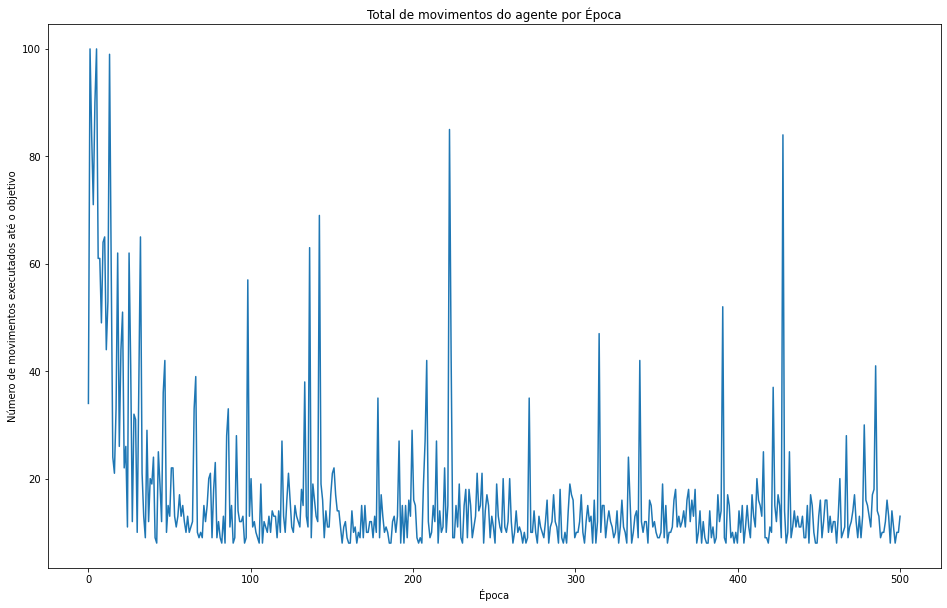

In [8]:
x = np.linspace(0, len(ag.moves), len(ag.moves))

plt.figure(figsize=(16, 10))
plt.plot(x, ag.moves)
plt.ylabel("Número de movimentos executados até o objetivo")
plt.xlabel("Época")
plt.title("Total de movimentos do agente por Época")
plt.show()

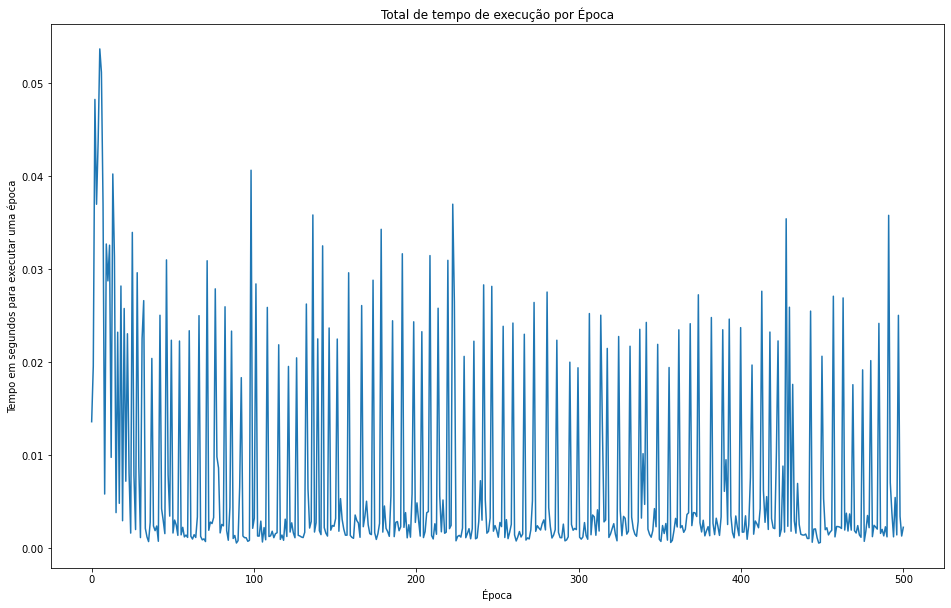

In [9]:
x = np.linspace(0, len(ag.time_epoch), len(ag.time_epoch))

plt.figure(figsize=(16, 10))
plt.plot(x, ag.time_epoch)
plt.ylabel('Tempo em segundos para executar uma época')
plt.xlabel('Época')
plt.title("Total de tempo de execução por Época")
plt.show()

Exemplos utilizados para construir esta simulação:

https://www.analyticsvidhya.com/blog/2021/04/q-learning-algorithm-with-step-by-step-implementation-using-python/
https://towardsdatascience.com/implement-grid-world-with-q-learning-51151747b455